In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cpi
import datetime
import seaborn as sns

In [2]:
# read in data
df = pd.read_csv('cleaned_data.csv')

# list all column names without ...
pd.set_option('display.max_columns', None)
df.head()

# Reporting Railroad Name, Accident Year, Accident Number, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name,
# Maintenance Accident Year, Maintenance Accident Month, Maintenance Accident Number, Grade Crossing ID, Date, Subdivision, Division Code, Division, State Abbreviation,
# Track Name, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3, 
# First Car Initials, First Car Number, Causing Car Initials, Causing Car Number, Narrative, Incident Key, Report Key, Reporting Railroad SMT Grouping,
# Other Railroad SMT Grouping, Maintenance Railroad SMT Grouping, Reporting Railroad SMT Grouping Name, Other Railroad SMT Grouping Name, Maintenance Railroad SMT Grouping,

C:\Users\Gian\AppData\Local\Temp\ipykernel_2620\769694212.py:2: DtypeWarning: Columns (21,22,36,37,46,47,48,49,50,51,52,53,54,56,110,111,112,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


,Reporting Railroad Name,Report Year,Accident Number,Accident Year,Accident Month,Other Railroad Name,Other Accident Number,Other Accident Year,Other Accident Month,Maintenance Railroad Name,Maintenance Accident Number,Maintenance Accident Year,Maintenance Accident Month,Grade Crossing ID,Day,Date,Time,Accident Type,Hazmat Cars,Hazmat Cars Damaged,Hazmat Released Cars,Persons Evacuated,Subdivision,Division Code,Division,Station,Milepost,State Abbreviation,State Name,County Name,District,Temperature,Visibility,Weather Condition,Track Type,Track Name,Track Class,Track Density,Train Direction,Equipment Type,Equipment Attended,Train Number,Train Speed,Recorded Estimated Speed,Maximum Speed,Gross Tonnage,Signalization,Method of Operation,Adjunct Code 1,Adjunct Code Name 1,Adjunct Code 2,Adjunct Code Name 2,Adjunct Code 3,Adjunct Code Name 3,Remote Control Locomotive,First Car Initials,First Car Number,First Car Position,First Car Loaded,Causing Car Initials,Causing Car Number,Causing Car Position,Causing Car Loaded,Positive Alcohol Tests,Positive Drug Tests,Passengers Transported,Head End Locomotives,Mid Train Manual Locomotives,Mid Train Remote Locomotives,Rear End Manual Locomotives,Rear End Remote Locomotives,Derailed Head End Locomotives,Derailed Mid Train Manual Locomotives,Derailed Mid Train Remote Locomotives,Derailed Rear End Manual Locomotives,Derailed Rear End Remote Locomotives,Loaded Freight Cars,Loaded Passenger Cars,Empty Freight Cars,Empty Passenger Cars,Cabooses,Derailed Loaded Freight Cars,Derailed Loaded Passenger Cars,Derailed Empty Freight Cars,Derailed Empty Passenger Cars,Derailed Cabooses,Equipment Damage Cost,Track Damage Cost,Total Damage Cost,Primary Accident Cause,Contributing Accident Cause,Engineers On Duty,Firemen On Duty,Conductors On Duty,Brakemen On Duty,Hours Engineers On Duty,Minutes Engineers On Duty,Hours Conductors On Duty,Minutes Conductors On Duty,Railroad Employees Killed,Railroad Employees Injured,Passengers Killed,Passengers Injured,Others Killed,Others Injured,Persons Killed For Reporting Railroad,Persons Injured For Reporting Railroad,Total Persons Killed,Total Persons Injured,Total Killed Form 54,Total Injured Form 54,Special Study 1,Special Study 2,Latitude,Longitude,Narrative,Joint Track Type,Joint Track Class,Class,Joint CD,Incident Key,Report Key,Reporting Railroad Company Grouping,Reporting Railroad Class,Reporting Railroad SMT Grouping,Reporting Parent Railroad Company Name,Reporting Railroad Holding Company,Other Railroad Company Grouping,Other Railroad Class,Other Railroad SMT Grouping,Other Parent Railroad Company Name,Other Railroad Holding Company,Maintenance Railroad Company Grouping,Maintenance Railroad Class,Maintenance Railroad SMT Grouping,Maintenance Parent Railroad Company Name,Maintenance Railroad Holding Company
0,Northern Indiana Commuter Transportation District,2017.0,N1700013,17.0,6.0,NaN,NaN,NaN,NaN,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,201707188,17.0,6.0,NaN,6.0,06/06/2017,2:14 PM,Derailment,0.0,0.0,0.0,149,SYSTEM,NaN,NaN,CHICAGO,.55,IL,ILLINOIS,COOK,4.0,65.0,Day,Clear,Yard,YARD LEAD,1,NaN,North,Commuter Train - Pulling,Yes,918,10.0,Estimated,10,0,Not Signaled,Other Than Main Track,NaN,NaN,NaN,NaN,NaN,NaN,Not a remotely controlled operation,NICD,000203,2.0,No,NaN,NaN,0.0,NaN,0.0,0.0,Yes,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,"98,627",0,"132,013",Switch point worn or broken,NaN,1.0,NaN,1.0,NaN,1.0,56.0,1.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,OTH,000-000-000,41.884035,-87.623003,TRAIN 918 (NICD WB TRAIN 18) DERAILED WHILE PA...,Yard,1,No,1.0,NIRC201707188201706,NICDN1700013201706,Passenger (Formerly Commuter),Class 3,SMT-4 - CP/CN/CCD,Northern Indiana Commuter Transportation District,Not Assigned,NaN,NaN,NaN,NaN,NaN,Passenger (Formerly Commuter),Class 3,SMT-4 - CP/CN/CCD,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,Not Assigned
1,NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP...,2017.0,201707

## Preprocessing pipeline

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.compose import make_column_selector as selector

def before_preprocess(data):
    num_data = data.select_dtypes(include=['float64', 'int64'])
    cat_data = data.select_dtypes(include=['object'])
    cat_data.fillna('NA', inplace=True)
    cat_data = cat_data.astype(str)
    new_dat = pd.concat([num_data,cat_data], axis=1)
    return new_dat

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude=object)),
        ("cat", categorical_transformer, selector(dtype_include=object)),
    ]
)

## Average Damage Cost Per Year

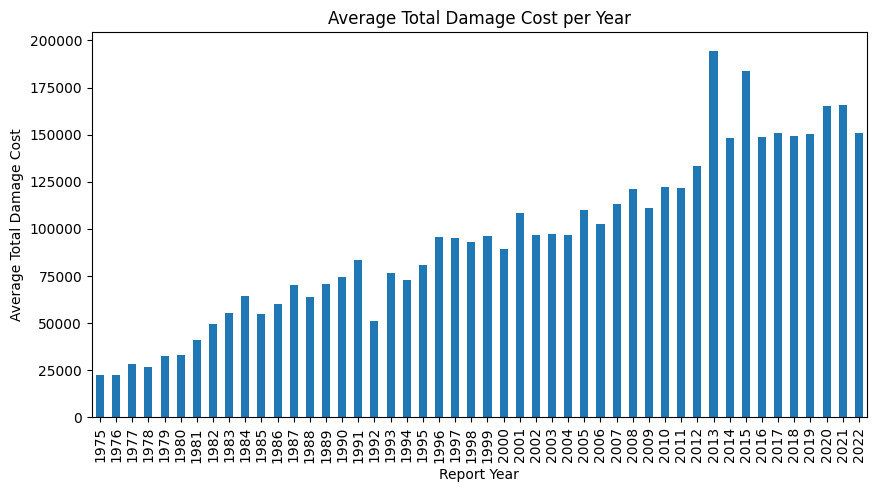

In [4]:
# Drop all rows with NA in Report Year or Total Damage Cost
df = df.dropna(subset=['Report Year', 'Total Damage Cost'])

# Convert Report Year to int
df['Report Year'] = df['Report Year'].astype(int)

# Remove commas from Total Damage Cost
df['Total Damage Cost'] = df['Total Damage Cost'].astype(str).str.replace(',', '')

# Convert Total Damage Cost to int
df['Total Damage Cost'] = df['Total Damage Cost'].astype(float).astype(int)

# Find average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean()

# Plot average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].mean().plot(kind='bar', figsize=(10, 5))
plt.title('Average Total Damage Cost per Year')
plt.xlabel('Report Year')
plt.ylabel('Average Total Damage Cost')
plt.show()


## Average Damage Cost Per Year (Adjusted for Inflation)

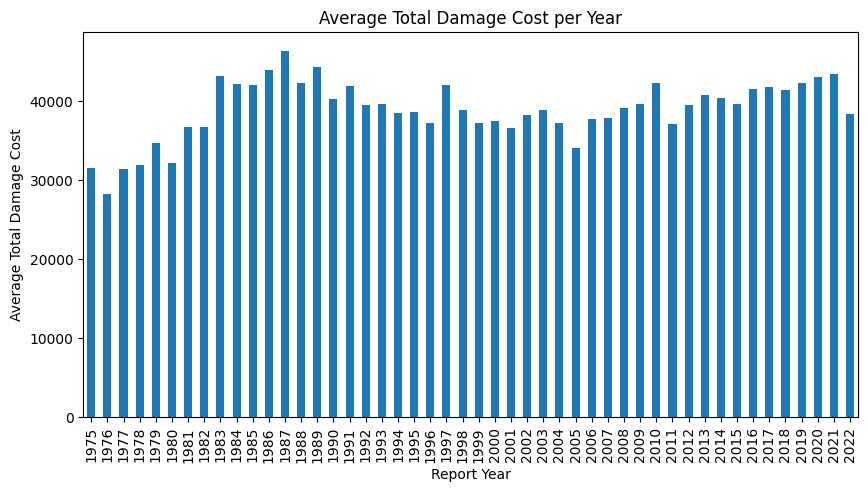

In [5]:
# Adjust for inflation
df['Total Damage Cost'] = df.apply(lambda row: cpi.inflate(row['Total Damage Cost'], row['Report Year']), axis=1)

# Find average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].median()

# Plot average Total Damage Cost per year
df.groupby('Report Year')['Total Damage Cost'].median().plot(kind='bar', figsize=(10, 5))
plt.title('Average Total Damage Cost per Year')
plt.xlabel('Report Year')
plt.ylabel('Average Total Damage Cost')
plt.show()

### By Accident Type

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, 'RR grade crossing'),
  Text(1, 0, 'Head on collision'),
  Text(2, 0, 'Explosion-detonation'),
  Text(3, 0, 'Rear end collision'),
  Text(4, 0, 'Broken train collision'),
  Text(5, 0, 'Derailment'),
  Text(6, 0, 'Hwy-rail crossing'),
  Text(7, 0, 'Fire/violent rupture'),
  Text(8, 0, 'Obstruction'),
  Text(9, 0, 'Raking collision'),
  Text(10, 0, 'Side collision'),
  Text(11, 0, 'Other'),
  Text(12, 0, 'Other impacts')])

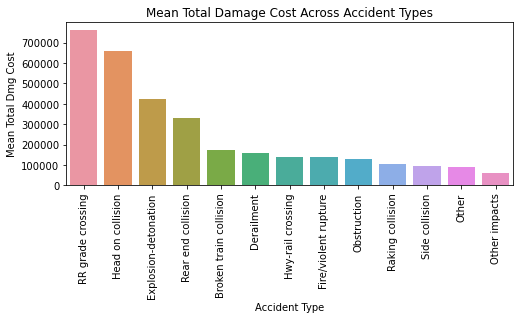

In [25]:
accident_cost = df.groupby('Accident Type')['Total Damage Cost'].mean().sort_values(ascending=False).reset_index()
accident_cost['Accident Type'] = accident_cost['Accident Type'].replace('Other (describe in narrative)','Other')

plt.figure(figsize=(8,3))
sns.barplot(data=accident_cost, x='Accident Type', y='Total Damage Cost')
plt.title('Mean Total Damage Cost Across Accident Types')
plt.ylabel('Mean Total Dmg Cost')
plt.xticks(rotation=90)

### By Company

In [ ]:
comp_df = df.groupby(['Reporting Railroad Name', 'Report Year'])['Total Damage Cost'].mean().sort_values(ascending=False).reset_index()
comp_df = comp_df.rename(columns={'Total Damage Cost': 'Mean Cost by Company/Year'})
mean_by_year = df.groupby('Report Year')['Total Damage Cost'].mean().reset_index()
comp_df = comp_df.merge(mean_by_year, on='Report Year')
comp_df = comp_df.rename(columns={'Total Damage Cost': 'Mean Cost by Year'})
comp_df.head()

top_5_by_year = comp_df.groupby('Report Year').apply(lambda x: x.nlargest(5, 'Mean Cost by Company/Year')).reset_index(drop=True)
pd.set_option('display.max_rows', None)
top_5_by_year.dtypes
print(top_5_by_year['Reporting Railroad Name'].value_counts())

sns.barplot(data=top_5_by_year, x='Report Year', y='Mean Cost by Company/Year', hue='Reporting Railroad Name').legend_.remove()
plt.title('Companies With Highest Mean Loss Per Year')
plt.show()




AN Railway LLC                                              6
Long Island Rail Road                                       6
Amtrak (National Railroad Passenger Corporation)            6
Southern California Regional Rail Authority                 6
Denver & Rio Grande Western Railroad Company                6
NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP. -- METRA    5
Autotrain Corporation                                       4
Florida East Coast Railway Company                          4
Duluth, Winnipeg & Pacific Railway                          4
Northern Indiana Commuter Transportation District           4
Arizona & California Railroad Company                       4
Indiana Rail Road Company                                   4
Kyle Railroad Company                                       4
Texas Mexican Railway Company                               3
Cedar Rapids & Iowa City Railway Company                    3
New England Central Railroad                                3
Central 

KeyboardInterrupt: 

Still having issues, the plot is trying to plot every possible company for every year but I only want it to show the 5 top companies associated to each year 

In [ ]:
top_10_by_year = comp_df.groupby('Report Year').apply(lambda x: x.nlargest(10, 'Mean Cost by Company/Year')).reset_index(drop=True)
pd.set_option('display.max_rows', None)
top_10_by_year['Reporting Railroad Name'].value_counts()

top_3 = ['Long Island Rail Road','Amtrak (National Railroad Passenger Corporation)','Denver & Rio Grande Western Railroad Company']


Long Island Rail Road                                           12
Amtrak (National Railroad Passenger Corporation)                10
Denver & Rio Grande Western Railroad Company                    10
NORTHEAST ILLINOIS REGIONAL COMMUTER RAIL CORP. -- METRA         9
AN Railway LLC                                                   8
Southern California Regional Rail Authority                      8
Arizona & California Railroad Company                            8
Florida East Coast Railway Company                               7
Northern Indiana Commuter Transportation District                6
Indiana Rail Road Company                                        6
Texas Mexican Railway Company                                    6
Kyle Railroad Company                                            6
New York, Susquehanna & Western Railroad Company                 5
New England Central Railroad                                     5
CINCINNATI, NEW ORLEANS & TEXAS PACIFIC RAILWAY               

### Linear Regression to See if Slope is Positive

MSE: 411191746.32
R^2: 0.34


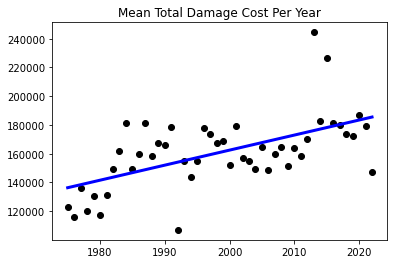

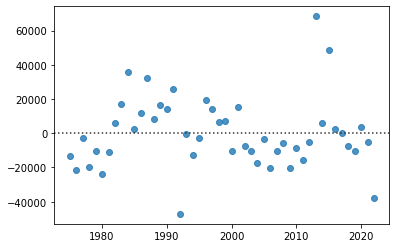

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols

lin_reg_df = df.groupby('Report Year')['Total Damage Cost'].mean().reset_index()
lin_reg_df = lin_reg_df.rename(columns={'Total Damage Cost': 'Mean Cost'})

X = lin_reg_df['Report Year'].array.reshape(-1, 1)
Y = lin_reg_df['Mean Cost'].array.reshape(-1, 1)

lin_reg = LinearRegression().fit(X,Y)
pred = lin_reg.predict(X)

print("MSE: %.2f" % mean_squared_error(Y, pred))
print("R^2: %.2f" % r2_score(Y, pred))


plt.scatter(X, Y, color="black")
plt.plot(X, pred, color="blue", linewidth=3)
plt.title("Mean Total Damage Cost Per Year")
plt.show()

# checking residuals
sns.residplot(x=X, y=Y)
plt.show()


                            OLS Regression Results                            
Dep. Variable:              Mean_Cost   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     23.48
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           1.47e-05
Time:                        00:52:12   Log-Likelihood:                -544.14
No. Observations:                  48   AIC:                             1092.
Df Residuals:                      46   BIC:                             1096.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.929e+06   4.31e+05     -4.473      

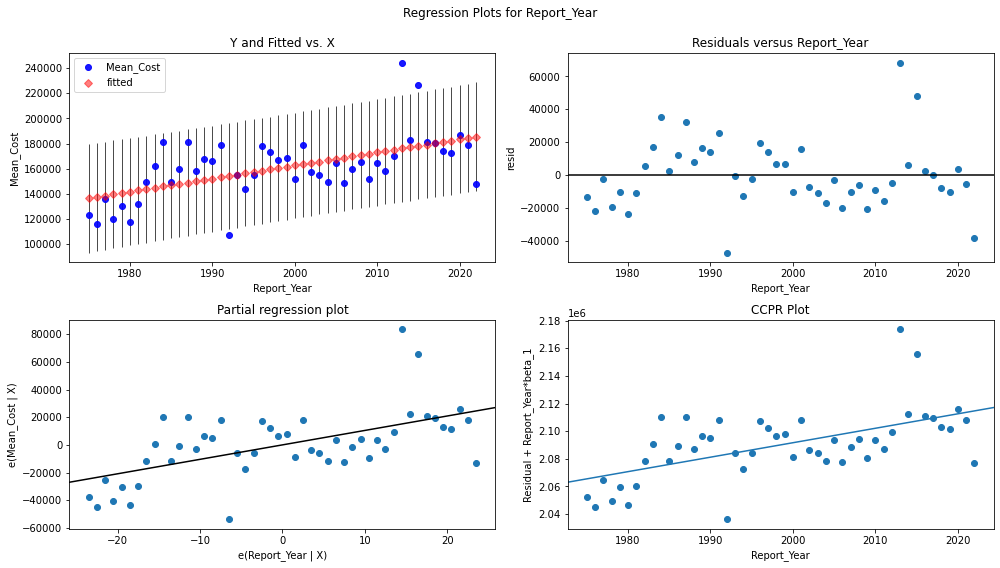

In [ ]:
# using ols
lin_reg_df = lin_reg_df.rename(columns={'Mean Cost':'Mean_Cost',
                                        'Report Year': 'Report_Year'})
linear_model = ols('Mean_Cost ~ Report_Year',data=lin_reg_df).fit() 
# display model summary
print(linear_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(linear_model,
                                    'Report_Year',
                                    fig=fig)

## Correlation Between Select Features

In [8]:
# remove
# Reporting Railroad Name, Accident Year, Accident Number, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name,
# Maintenance Accident Year, Maintenance Accident Month, Maintenance Accident Number, Grade Crossing ID, Date, Subdivision, Division Code, Division, State Abbreviation,
# Track Name, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3,
# First Car Initials, First Car Number, Causing Car Initials, Causing Car Number, Narrative, Incident Key, Report Key, Reporting Railroad SMT Grouping,
# Other Railroad SMT Grouping, Maintenance Railroad SMT Grouping, Reporting Railroad SMT Grouping Name, Other Railroad SMT Grouping Name, Maintenance Railroad SMT Grouping
df_reduced = df.drop(
    [
        "Accident Year",
        "Accident Number",
        "Other Railroad Name",
        "Other Accident Number",
        "Other Accident Year",
        "Other Accident Month",
        "Maintenance Railroad Name",
        "Maintenance Accident Year",
        "Maintenance Accident Month",
        "Maintenance Accident Number",
        "Grade Crossing ID",
        "Date",
        "Subdivision",
        "Division Code",
        "Division",
        "State Abbreviation",
        "Track Name",
        "Adjunct Code 1",
        "Adjunct Code Name 1",
        "Adjunct Code 2",
        "Adjunct Code Name 2",
        "Adjunct Code 3",
        "Adjunct Code Name 3",
        "First Car Initials",
        "First Car Number",
        "Causing Car Initials",
        "Causing Car Number",
        "Narrative",
        "Incident Key",
        "Report Key",
        "Reporting Railroad SMT Grouping",
        "Other Railroad SMT Grouping",
        "Maintenance Railroad SMT Grouping",
        "Maintenance Railroad SMT Grouping",
    ],
    axis=1,
)

In [10]:
top_3 = ['Long Island Rail Road','Amtrak (National Railroad Passenger Corporation)','Denver & Rio Grande Western Railroad Company']

corr = df_reduced
print(corr)
for comp in top_3:
    corr = corr[corr['Reporting Railroad Name']==comp]
    corr = corr.drop('Total Damage Cost', axis=1)
    corr = corr.transpose()
    cor_val = 0.05
    corr = corr[(corr > cor_val) | (corr < -cor_val)]
    corr = corr.dropna(axis=1)

    plt.figure(figsize=(16, 4))
    sns.heatmap(corr, annot=True, annot_kws={"rotation": 90}, fmt=".2f", cmap="coolwarm", yticklabels=True)

                              Reporting Railroad Name  Report Year  \
0                    Norfolk Southern Railway Company         2016   
1                    Norfolk Southern Railway Company         2016   
2                                             Conrail         1981   
3                    Norfolk Southern Railway Company         2016   
4                    Norfolk Southern Railway Company         2016   
...                                               ...          ...   
216095                      Indiana Rail Road Company         2005   
216096  Indiana & Ohio Central Railroad, Incorporated         2005   
216097  Indiana & Ohio Central Railroad, Incorporated         2005   
216098  Indiana & Ohio Central Railroad, Incorporated         2005   
216099  Indiana & Ohio Central Railroad, Incorporated         2005   

        Accident Month   Day      Time   Accident Type  Hazmat Cars  \
0                  4.0   9.0   5:30 AM      Derailment          0.0   
1                

TypeError: '>' not supported between instances of 'str' and 'float'

### Total Damage Cost

In [ ]:
df_reduced.drop("Reporting Railroad Name",axis=1)

C:\Users\Gian\AppData\Local\Temp\ipykernel_7560\2420113797.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_reduced.corr()


<Axes: >

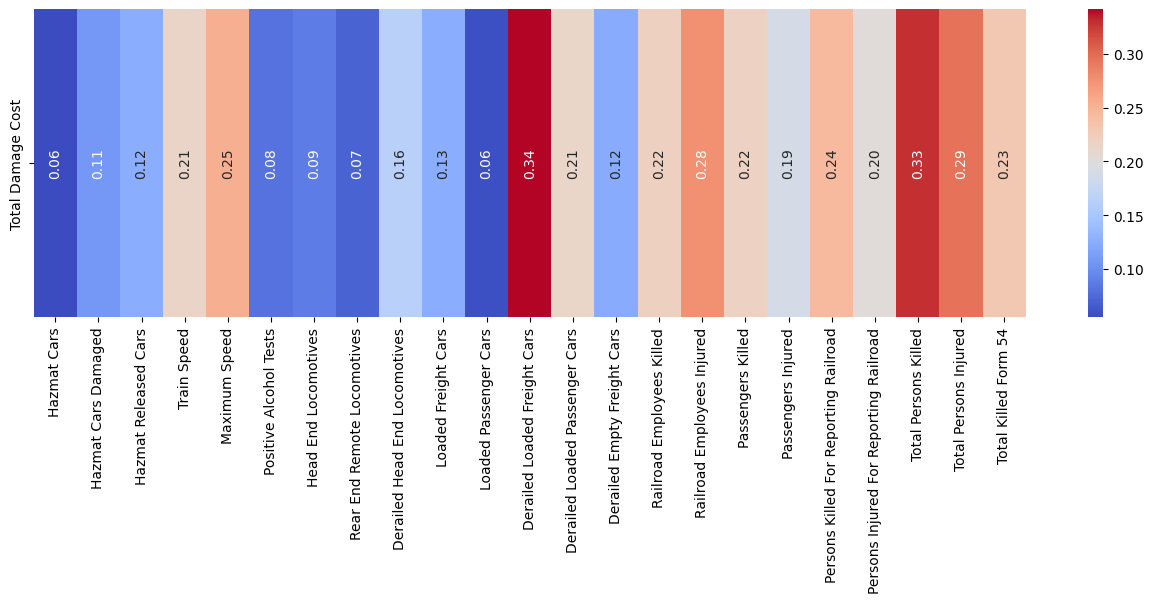

In [ ]:
# Over time has Total Damage Cost decreased? And what has caused this decrease?

# correlation matrix
corr = df_reduced.corr()
# only show correlation row for Total Damage Cost
corr = corr[['Total Damage Cost']]
# print(corr)

# remove Total Damage Cost from the correlation matrix
corr = corr.drop('Total Damage Cost', axis=0)

# flip the correlation matrix
corr = corr.transpose()

cor_val = 0.05
# remove any values that have an absolute value less than cor_val
corr = corr[(corr > cor_val) | (corr < -cor_val)]
corr = corr.dropna(axis=1)

# make the seaborn plot bigger
plt.figure(figsize=(16, 4))

# plot the heatmap with the annotation values rotated vertical using annot_kws
sns.heatmap(corr, annot=True, annot_kws={"rotation": 90}, fmt=".2f", cmap="coolwarm", yticklabels=True)

## Modeling Total Damage Cost

In [13]:
column_names = df.columns
column_names

Index(['Reporting Railroad Name', 'Report Year', 'Accident Year',
       'Accident Month', 'Other Railroad Name', 'Other Accident Number',
       'Other Accident Year', 'Other Accident Month',
       'Maintenance Railroad Name', 'Maintenance Accident Year',
       ...
       'Other Railroad Company Grouping', 'Other Railroad Class',
       'Other Railroad SMT Grouping', 'Other Parent Railroad Company Name',
       'Other Railroad Holding Company',
       'Maintenance Railroad Company Grouping', 'Maintenance Railroad Class',
       'Maintenance Railroad SMT Grouping',
       'Maintenance Parent Railroad Company Name',
       'Maintenance Railroad Holding Company'],
      dtype='object', length=130)

In [7]:
model_dat = df.loc[:,
        ['Reporting Railroad Name',
        'Report Year',
        'Accident Year',
        'Accident Month',
        'Other Railroad Name',
        'Maintenance Railroad Name',
        'Grade Crossing ID',
        'Day',
        'Date',
        'Time',
        'Accident Type',
        'Hazmat Cars',
        'Hazmat Cars Damaged',
        'Hazmat Released Cars',
        'Persons Evacuated',
        'Subdivision',
        'Division',
        'Station',
        'Milepost',
        'State Abbreviation',
        'County Name',
        'District',
        'Temperature',
        'Visibility',
        'Weather Condition',
        'Track Type',
        'Track Class',
        'Track Density',
        'Train Direction',
        'Equipment Type',
        'Equipment Attended',
        'Train Speed',
        'Recorded Estimated Speed',
        'Maximum Speed',
        'Gross Tonnage',
        'Signalization',
        'Method of Operation',
        'First Car Position',
        'First Car Loaded',
        'Causing Car Position',
        'Causing Car Loaded',
        'Positive Alcohol Tests',
        'Positive Drug Tests',
        'Passengers Transported',
        'Loaded Freight Cars',
        'Loaded Passenger Cars',
        'Empty Freight Cars',
        'Empty Passenger Cars',
        'Cabooses',
        'Total Damage Cost',
        'Primary Accident Cause',
        'Contributing Accident Cause',
        'Engineers On Duty',
        'Firemen On Duty',
        'Conductors On Duty',
        'Brakemen On Duty',
        'Hours Engineers On Duty',
        'Minutes Engineers On Duty',
        'Hours Conductors On Duty',
        'Minutes Conductors On Duty',
        'Total Persons Killed',
        'Total Persons Injured',
        'Latitude',
       'Longitude',
        'Joint Track Type',
        'Joint Track Class',
        'Class']]

In [15]:
list[model_dat.columns]

list[Index(['Reporting Railroad Name', 'Report Year', 'Accident Year',
       'Accident Month', 'Other Railroad Name', 'Maintenance Railroad Name',
       'Grade Crossing ID', 'Day', 'Date', 'Time', 'Accident Type',
       'Hazmat Cars', 'Hazmat Cars Damaged', 'Hazmat Released Cars',
       'Persons Evacuated', 'Subdivision', 'Division', 'Station', 'Milepost',
       'State Abbreviation', 'County Name', 'District', 'Temperature',
       'Visibility', 'Weather Condition', 'Track Type', 'Track Class',
       'Track Density', 'Train Direction', 'Equipment Type',
       'Equipment Attended', 'Train Speed', 'Recorded Estimated Speed',
       'Maximum Speed', 'Gross Tonnage', 'Signalization',
       'Method of Operation', 'First Car Position', 'First Car Loaded',
       'Causing Car Position', 'Causing Car Loaded', 'Positive Alcohol Tests',
       'Positive Drug Tests', 'Passengers Transported', 'Loaded Freight Cars',
       'Loaded Passenger Cars', 'Empty Freight Cars', 'Empty Passenger Car

In [8]:
from random import sample
from sklearn.model_selection import train_test_split

# rows after conrail disbands
testing_dat = model_dat[model_dat['Report Year']>1999]
testing_dat = before_preprocess(testing_dat)

X = testing_dat.loc[:,testing_dat.columns!="Total Damage Cost"]
Y = testing_dat["Total Damage Cost"].astype(int)
print(Y.head())

# creating testing and training data
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=.3)

print("X-train shape: ", x_train.shape)
print("Y-train shape: ", y_train.shape)
print("X-test shape: ", x_test.shape)
print("Y-test shape: ", y_test.shape)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


0    50871
1    50871
3    37713
4    37713
5    19812
Name: Total Damage Cost, dtype: int64
X-train shape:  (49776, 66)
Y-train shape:  (49776,)
X-test shape:  (21333, 66)
Y-test shape:  (21333,)


### Random Forest for Predicting Total Damage Cost

In [9]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree

# turn conf matrix in df for visualization
def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

rf_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(max_features='sqrt'))]
)

rf_pipe.fit(x_train, y_train)
pred = rf_pipe.predict(x_test)
print(rf_pipe.score(x_test,y_test))
#conf_mat = confusion_matrix(y_test, pred)
#conf_mat_df = conf_matrix_to_df(conf_mat,testing_dat['Accident Type'].unique())
#conf_mat_df


0.37385643427853343


AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [ ]:
scores = cross_val_score(rf_pipe, x_test, y_test, cv=5)
scores.mean()

In [ ]:
# feature importance
importances = rf_pipe.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_pipe.estimators_], axis=0)
feature_names = testing_dat.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Multiple Linear Regression for Total Damage Cost

In [8]:
from sklearn.linear_model import LinearRegression

mlr_pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearRegression())]
)

mlr_pipe.fit(x_train, y_train)
pred = mlr_pipe.predict(x_test)
print(mlr_pipe.score(x_test,y_test))

: 

: 